In [30]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np


In [31]:
import numpy as np


def pressure_theoretical(r, R, LAMBDA):

    if LAMBDA == 0:
        return (R**2 - r**2)/4

    """
    Analytical solution for radial stress (Weady et al. 2024).
    """
    c = (np.sqrt(1 + LAMBDA * R**2 / 2) - 1) / (2 * LAMBDA * R**2)
    return np.maximum(2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2), 0)


def velocity_theoretical(r, R, LAMBDA):

    if LAMBDA == 0:
        return r/2

    """
    Analytical solution for radial stress (Weady et al. 2024).
    """
    c = (np.sqrt(1 + LAMBDA * R**2 / 2) - 1) / (2 * LAMBDA * R**2)
    return (32 * c**2 * r) / (1 - 8 * c**2 * LAMBDA * r**2)


def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


def compute_packing_fraction(shell_particles, r_inner, r_outer, mode="soft"):
    """
    Compute packing fraction of particles inside a radial shell.

    Args:
        shell_particles: DataFrame of particles within the shell
        r_inner: inner radius of the shell
        r_outer: outer radius of the shell
        mode: 'soft' or 'hard' (determines which length column to use)

    Returns:
        Packing fraction (float)
    """
    if len(shell_particles) == 0:
        return 0.0

    # Total particle area
    total_particle_area = sum(spherocylinder_area(length)
                              for length in shell_particles["length"])

    # Shell area
    shell_area = np.pi * (r_outer**2 - r_inner**2)

    return total_particle_area / shell_area

In [32]:
# Define colors for modes
MODE_COLORS = {"Hard": "blue", "Soft": "orange"}
LINE_STYLES = ["-", "--", "-.", ":"]  # cycle for different exponents
SYMBOLS = ["o", "s", "^", "D"]  # cycle for different exponents
SYMBOL_COLORS = ["blue", "orange", "green", "red", "purple", "brown"]


def get_style(mode, exp):
    """
    Returns (color, linestyle) based on sim_dir.
    Hard = blue, Soft = red.
    linestyle determined by exponent.
    """

    # cycle if more than 4 exponents

    linestyle = LINE_STYLES[(-exp) % len(LINE_STYLES)]
    symbol = SYMBOLS[(-exp) % len(SYMBOLS)]
    symbol_color = SYMBOL_COLORS[(-exp) % len(SYMBOL_COLORS)]

    return MODE_COLORS[mode] if mode in MODE_COLORS else "red", linestyle, symbol, symbol_color


def plot_radial_distribution(particles_dict, variable, bin_size=2.0, outname=None, plot_theory=False, xlabel=None, ylabel=None):
    """
    Plot radial distribution for multiple simulations.
    Can optionally overlay the theoretical solution for stress.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    outname = outname or f"combined_radial_{variable}.png"

    theoreticals = {}

    for (mode, exp, label), df in particles_dict.items():
        color, linestyle, symbol, symbol_color = get_style(mode, exp)
        df = df.copy()
        df["dist_center"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
        max_radius = int(df["dist_center"].max())

        r_edges = np.arange(0, max_radius + bin_size, bin_size)
        r_centers = 0.5 * (r_edges[1:] + r_edges[:-1])

        vals = []
        for i in range(len(r_centers)):
            mask = (df["dist_center"] >= r_edges[i]) & (
                df["dist_center"] < r_edges[i+1])
            shell = df[mask]
            if variable == "packing_fraction":
                length_col = [c for c in df.columns if "length" in c][0]
                val = compute_packing_fraction(
                    shell, r_edges[i], r_edges[i+1], length_col)
            else:
                val = shell[variable].mean() if len(shell) else 0
            vals.append(val)

        # ax.plot(r_centers, vals, color=color, linestyle=linestyle, label=label)
        ax.plot(r_centers, vals, symbol, ls=linestyle, color=color,
                linewidth=2, ms=10, mfc=color, mec='black', label=label, markevery=0.1)

        # Optional: plot theoretical stress curve
        if plot_theory and "stress" in variable.lower():
            max_radius = int(df["dist_center"].max())

            # round radius to nearest 5
            max_radius = 5 * round(max_radius / 5)
            if (max_radius, exp) in theoreticals:
                continue

            LAMBDA = 10**exp
            r_theory = np.linspace(0, max_radius+1, 100)
            pres = pressure_theoretical(r_theory, max_radius, LAMBDA)
            theoreticals[(max_radius, exp)] = (r_theory, pres)

        if plot_theory and "mag_velocity_linear" in variable.lower():
            max_radius = int(df["dist_center"].max())

            # round radius to nearest 5
            max_radius = 5 * round(max_radius / 5)
            if (max_radius, exp) in theoreticals:
                continue

            LAMBDA = 10**exp
            r_theory = np.linspace(0, max_radius+1, 100)
            pres = velocity_theoretical(r_theory, max_radius, LAMBDA)
            theoreticals[(max_radius, exp)] = (r_theory, pres)

    for ((r, key), (x, y)) in theoreticals.items():
        ax.plot(x, y,
                label="Theory ($\\lambda = 10^{" + str(key) + "}$))", color="black", linestyle="--")

    ax.set_xlabel(xlabel or "Radius $r$", fontsize=20)
    ax.set_ylabel(
        ylabel or f"$\\langle {variable.replace('_', '\\ ')} \\rangle$", fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # ax.set_title(f"Radial Distribution of {variable}", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=16)
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig


def plot_parameter_over_time(sim_dict, x, y, yscale=None, xscale=None, outname=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    outname = outname or f"combined_{x}_vs_{y}.png"

    for (mode, exp, label), df in sim_dict.items():
        color, linestyle, symbol, symbol_color = get_style(mode, exp)
        x_data, y_data = df[x], df[y]

        ax.plot(x_data, y_data, symbol, ls=linestyle, color=color,
                linewidth=2, ms=10, mfc=symbol_color, mec='black', label=label, markevery=0.1)

    if yscale == "log":
        ax.set_yscale("log")
    if xscale == "log":
        ax.set_xscale("log")

    ax.set_xlabel(xlabel or x, fontsize=20)
    ax.set_ylabel(ylabel or y, fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.grid(True)
    ax.legend(fontsize=16)
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig

In [33]:
from load_combined import load_combined

sim_dirs = [
    # "../data/growth_comparison/vtk_output_soft_1.000000e-01/",
    # "../data/growth_comparison/vtk_output_soft_1.000000e-02/",
    # "../data/growth_comparison/vtk_output_soft_1.000000e-03/",
    # "../data/growth_comparison/vtk_output_soft_1.000000e-04/",
    # "../data/growth_comparison/vtk_output_hard_1.000000e-01/",
    # "../data/growth_comparison/vtk_output_hard_1.000000e-02/",
    # "../data/growth_comparison/vtk_output_hard_1.000000e-03/",
    # "../data/growth_comparison/vtk_output_hard_1.000000e-04/",
    "../data/20250930_235905/vtk_output_hard_1.000000e-01/",
    "../data/20250930_235905/vtk_output_hard_1.000000e-02/",
    # "../data/20250930_235905/vtk_output_hard_1.000000e-03/",
    "../data/20250930_235905/vtk_output_hard_1.000000e-04/",
    "../data/20250930_235905/vtk_output_soft_1.000000e-01/",
    # "../data/20250930_235905/vtk_output_soft_1.000000e-02/",
    # "../data/20250930_235905/vtk_output_soft_1.000000e-03/",
    # "../data/20250930_235905/vtk_output_soft_1.000000e-04/",
    # "../code/cpp/build/src/vtk_output_soft/",
    "../data/20251001_113623/",
]
particles_dict, sim_dict, params_dict = load_combined(sim_dirs)

loading ../data/20250930_235905/vtk_output_hard_1.000000e-01/
loading ../data/20250930_235905/vtk_output_hard_1.000000e-02/
loading ../data/20250930_235905/vtk_output_hard_1.000000e-04/
loading ../data/20250930_235905/vtk_output_soft_1.000000e-01/
loading ../data/20251001_113623/


In [34]:
import pandas as pd
params = None
for df in params_dict.values():
    if params is None:
        params = df.loc[0]
    else:

        diff = params.compare(df.loc[0])
        # drop row mode
        diff = diff[diff.index != "mode"]

        if len(diff) > 0:
            print("Warning: Parameters differ between simulations:")
            print(diff)
            break

        self  other
LAMBDA   0.1   0.01


In [35]:
particles_dict[next(iter(particles_dict))].keys()

for df in particles_dict.values():
    df["mag_velocity_linear"] = np.sqrt(
        df["velocity_linear_x"]**2 + df["velocity_linear_y"]**2 + df["velocity_linear_z"]**2)
    df["mag_velocity_angular"] = np.sqrt(
        df["velocity_angular_x"]**2 + df["velocity_angular_y"]**2 + df["velocity_angular_z"]**2)
    

In [36]:
for df in sim_dict.values():
    # rename mpi_comm_time_s to wall_time_per_step
    df.rename(columns={
              "mpi_comm_time_s": "wall_time_per_step [s]",
              "dt_s": "dt",
              "cpu_time_s": "wall_time [s]",
              "simulation_time_s": "simulation_time [s]"}, inplace=True)

    df["wall_time_per_step_particle [s]"] = df["wall_time_per_step [s]"] / \
        df["num_particles"]

In [37]:
sim_dict[next(iter(sim_dict))].keys()

Index(['iteration', 'simulation_time [s]', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'wall_time [s]',
       'wall_time_per_step [s]', 'load_imbalance', 'dt', 'x', 'y', 'z', 'rank',
       'wall_time_per_step_particle [s]'],
      dtype='object')

In [38]:
particles_dict[next(iter(particles_dict))].keys()

Index(['gid', 'quaternion_x', 'quaternion_y', 'quaternion_z', 'quaternion_w',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_angle',
       'length', 'impedance', 'ldot', 'stress', 'number_of_constraints', 'age',
       'forces_x', 'forces_y', 'forces_z', 'velocity_linear_x',
       'velocity_linear_y', 'velocity_linear_z', 'velocity_angular_x',
       'velocity_angular_y', 'velocity_angular_z', 'rank', 'x', 'y', 'z',
       'mag_velocity_linear', 'mag_velocity_angular'],
      dtype='object')

In [39]:
particles_dict[next(iter(particles_dict))]["stress"]

0      5.06866
1     18.19870
2     20.26090
3     24.14160
4     11.70500
        ...   
17     1.96998
18     1.48409
19     3.38019
20     4.02254
21     1.76014
Name: stress, Length: 42509, dtype: float64

/tmp/ipykernel_1078333/1831546701.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


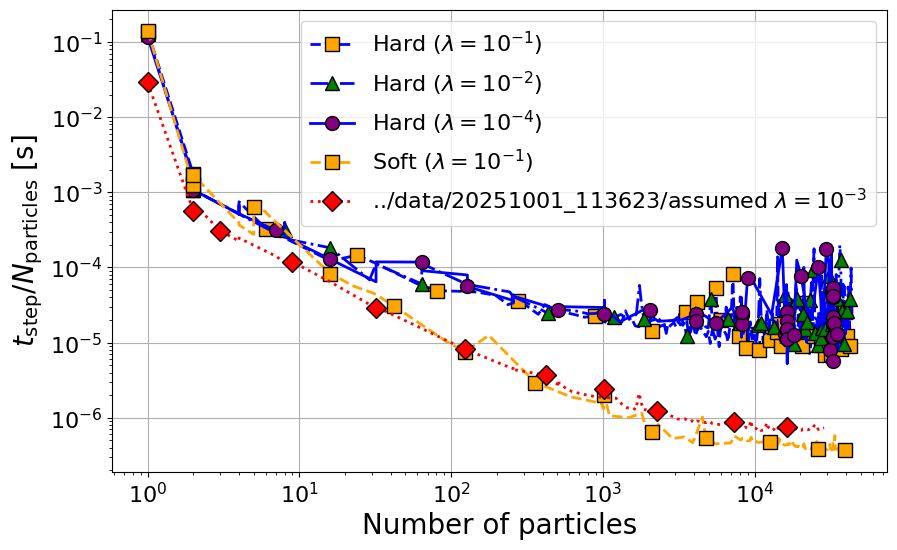

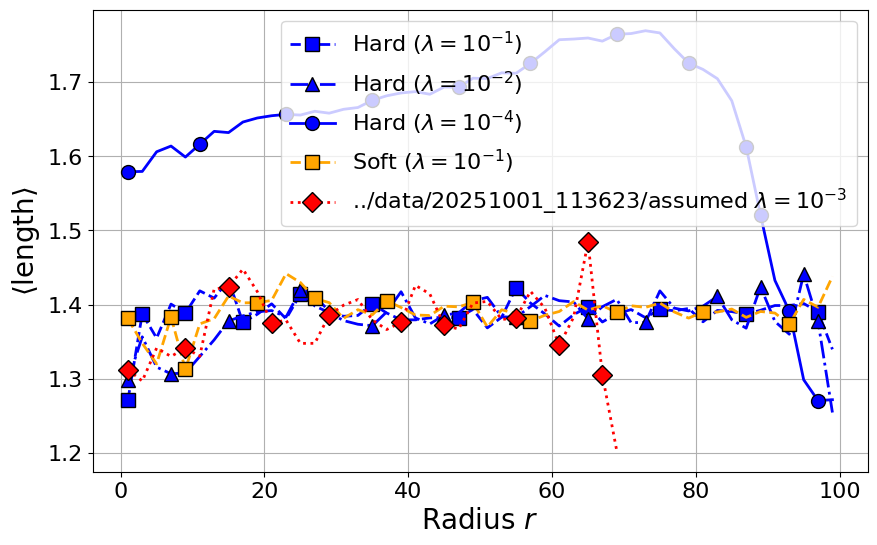

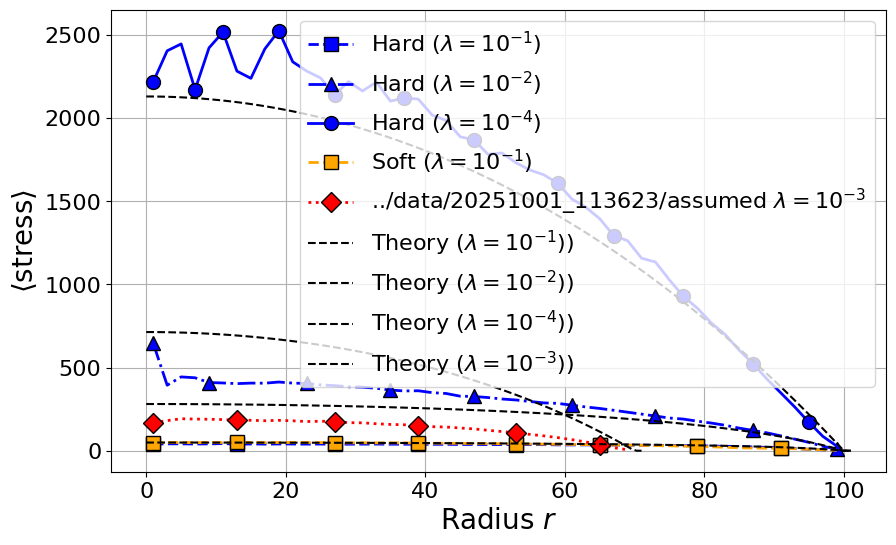

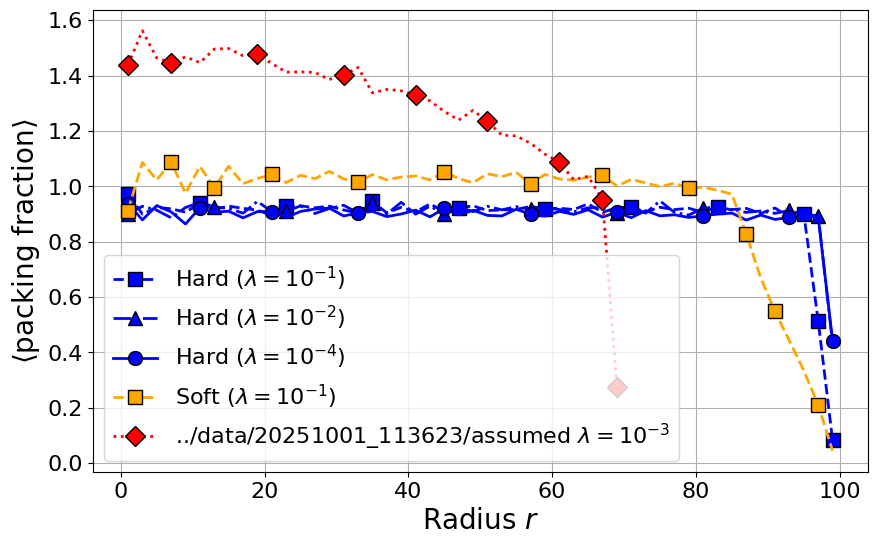

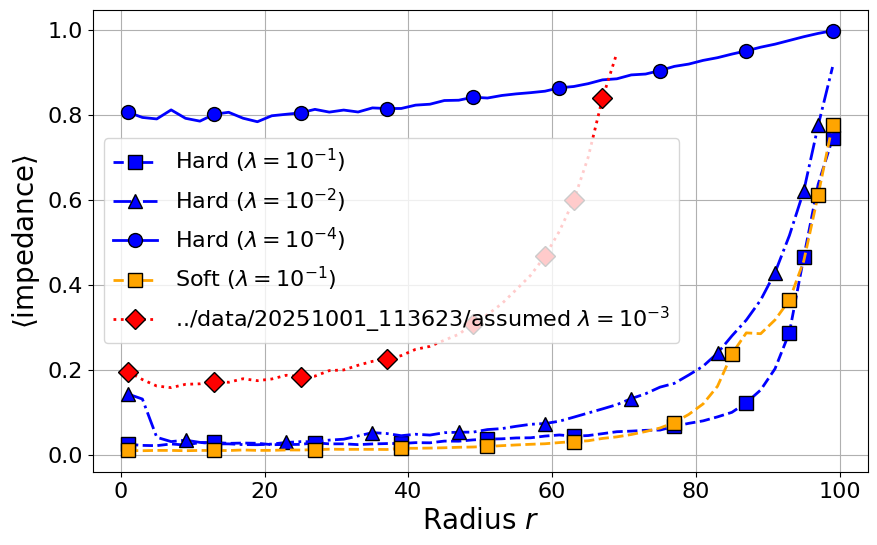

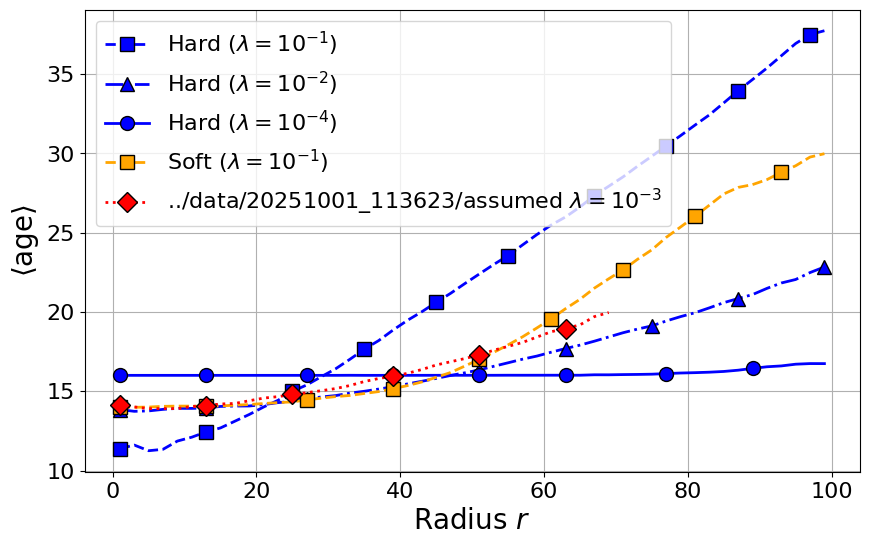

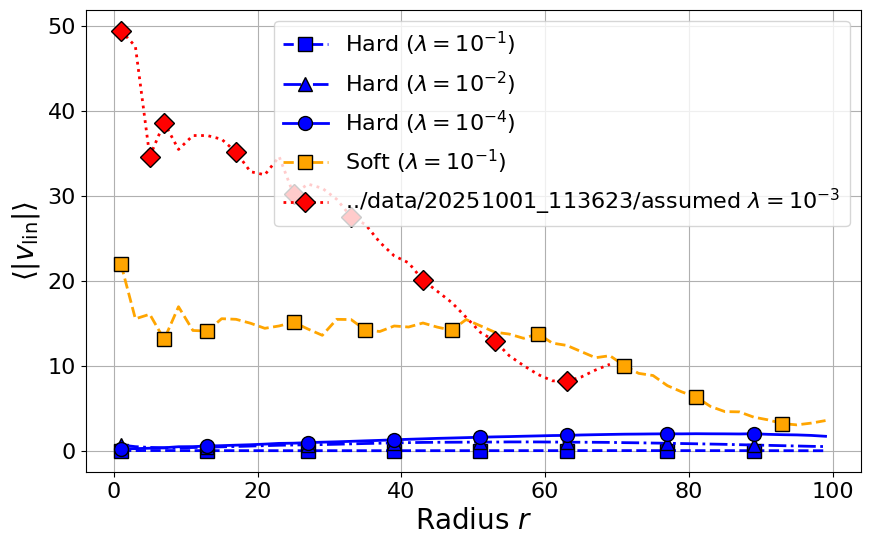

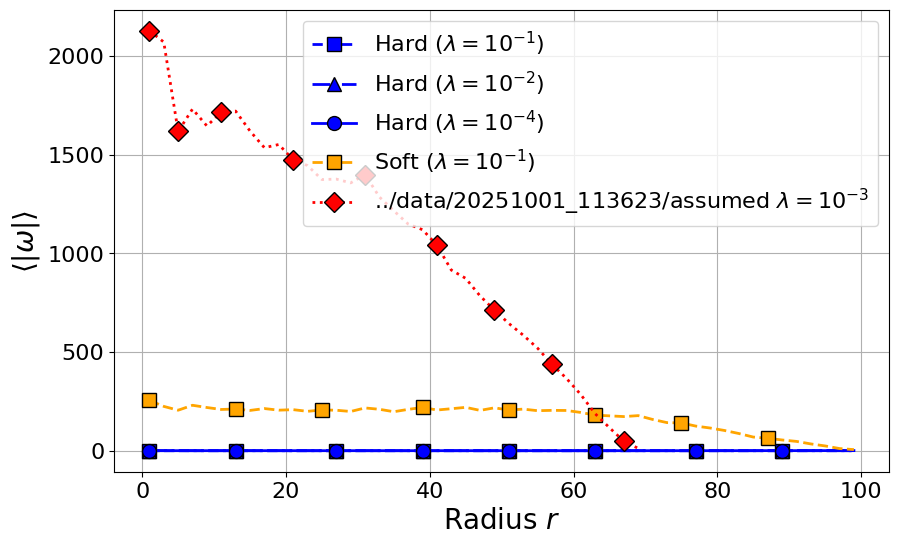

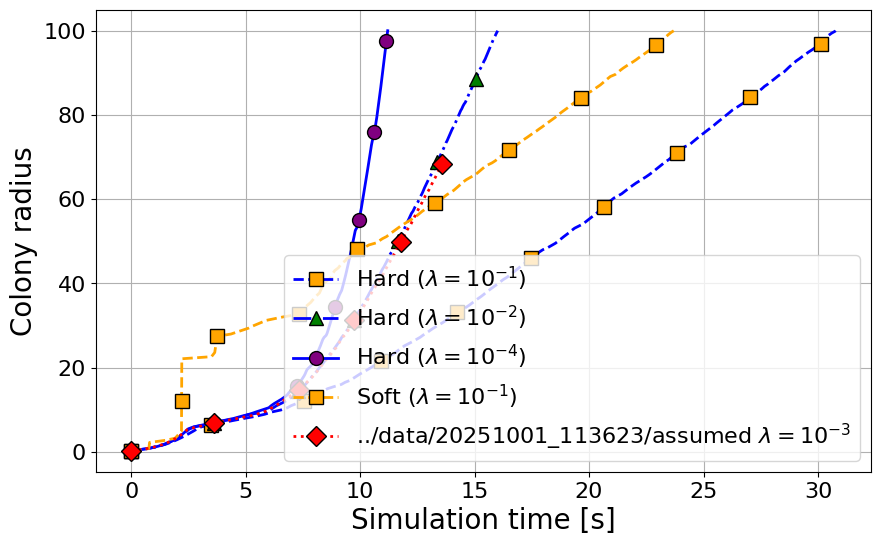

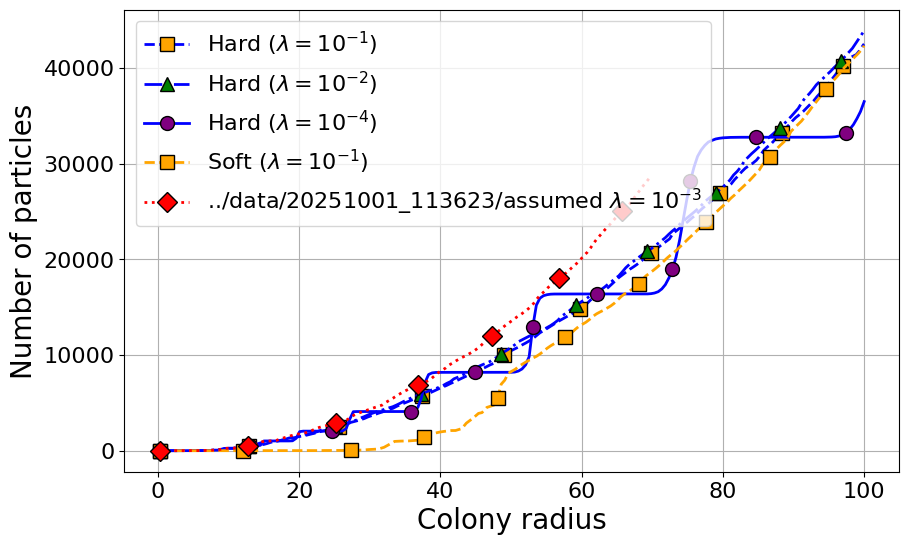

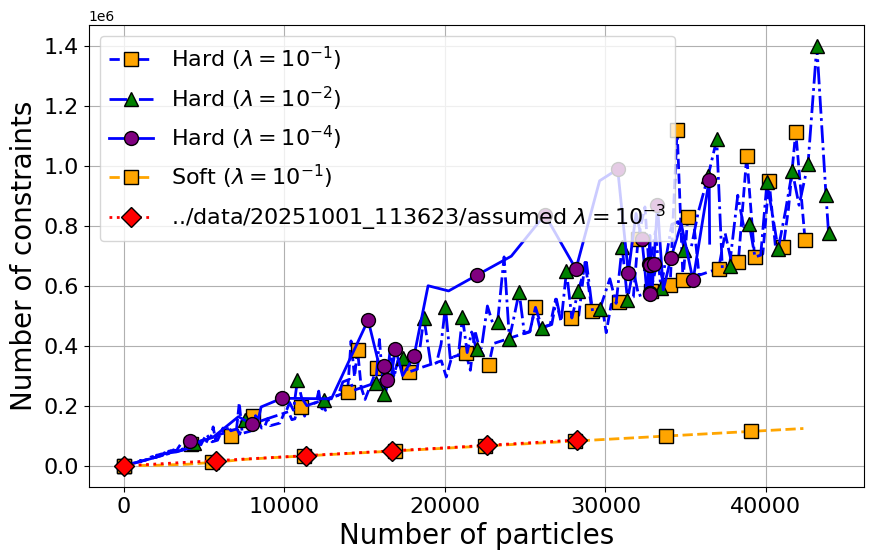

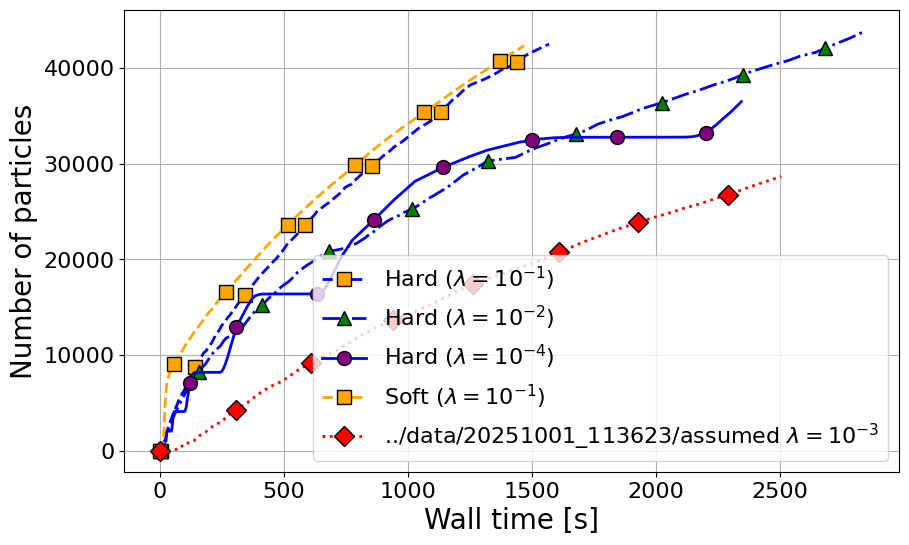

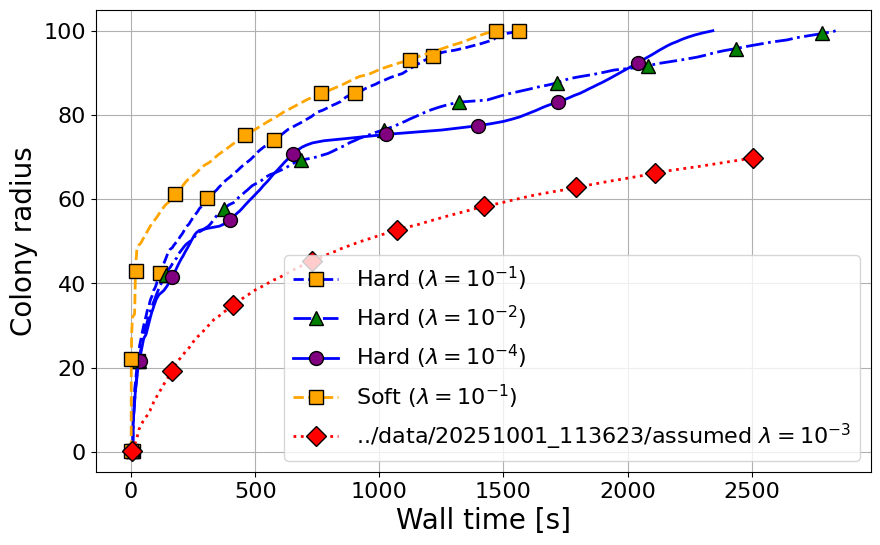

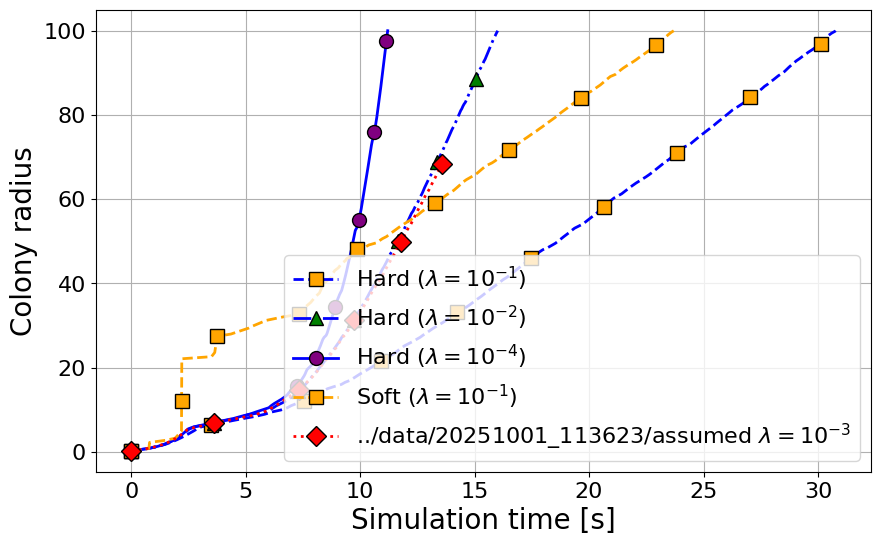

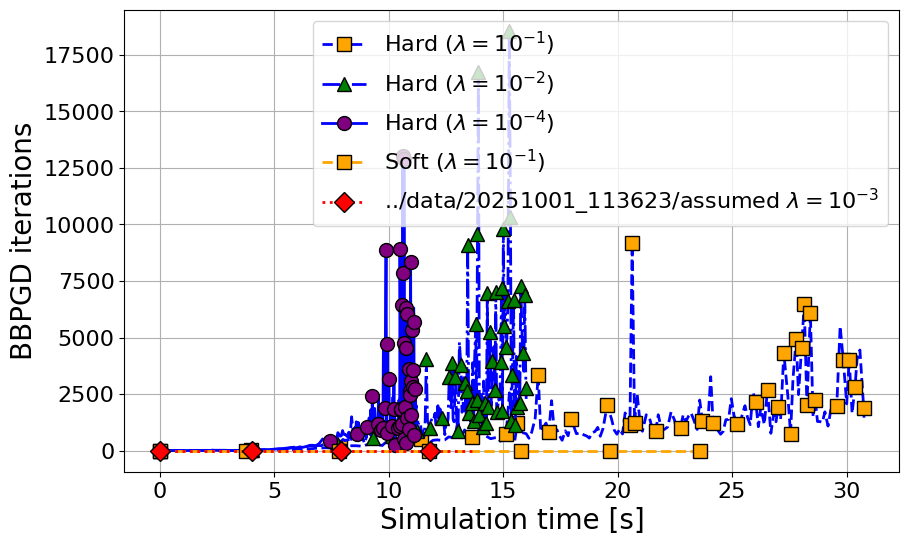

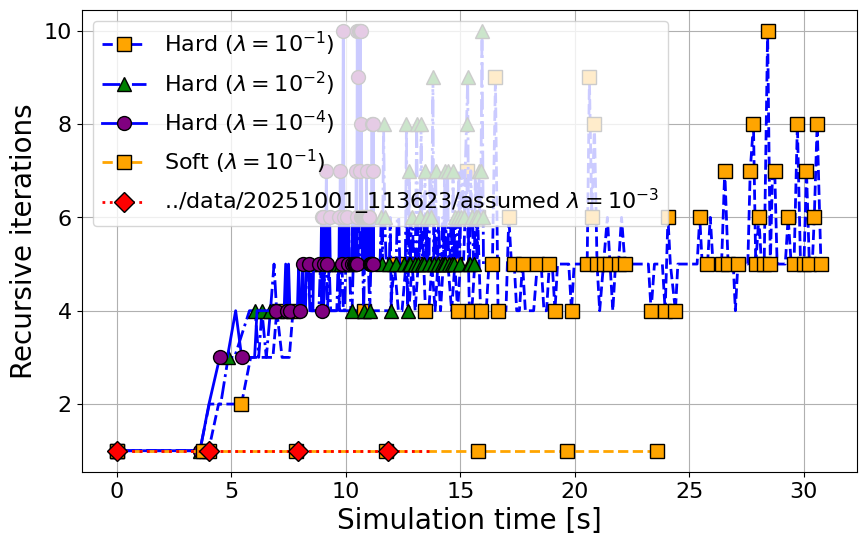

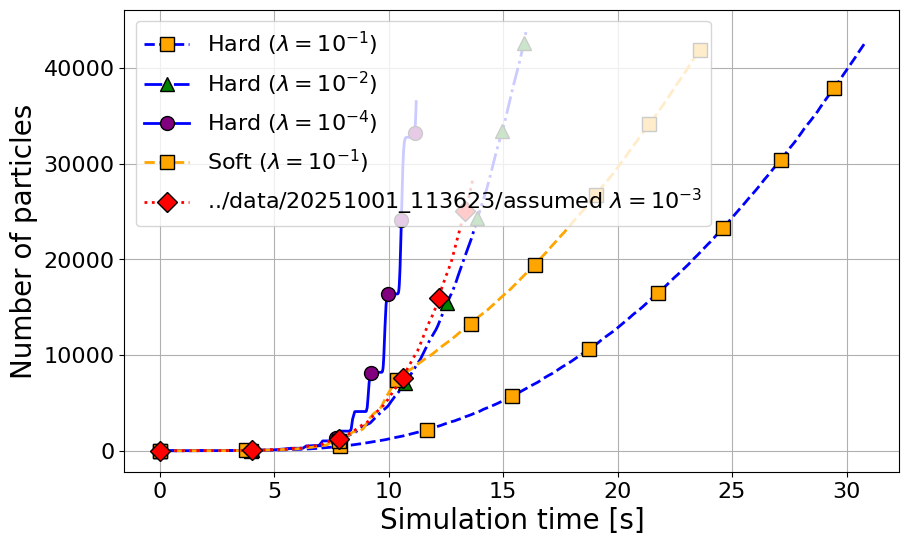

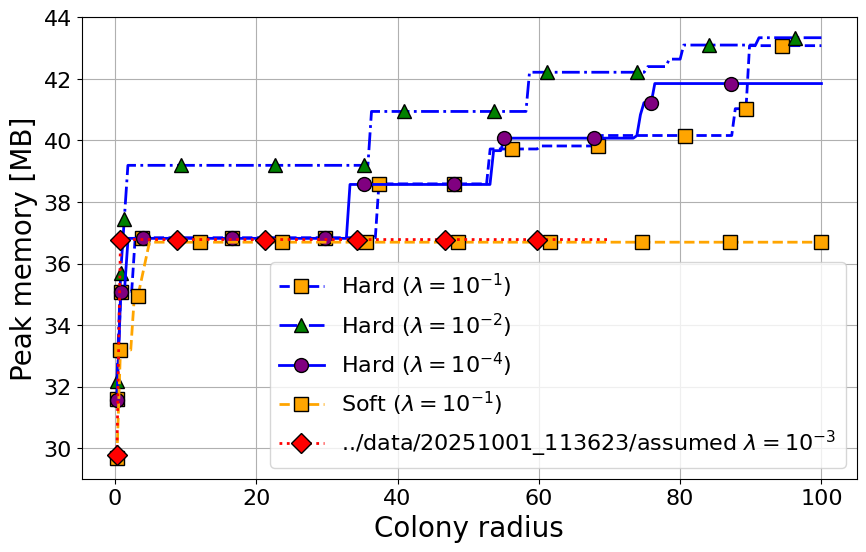

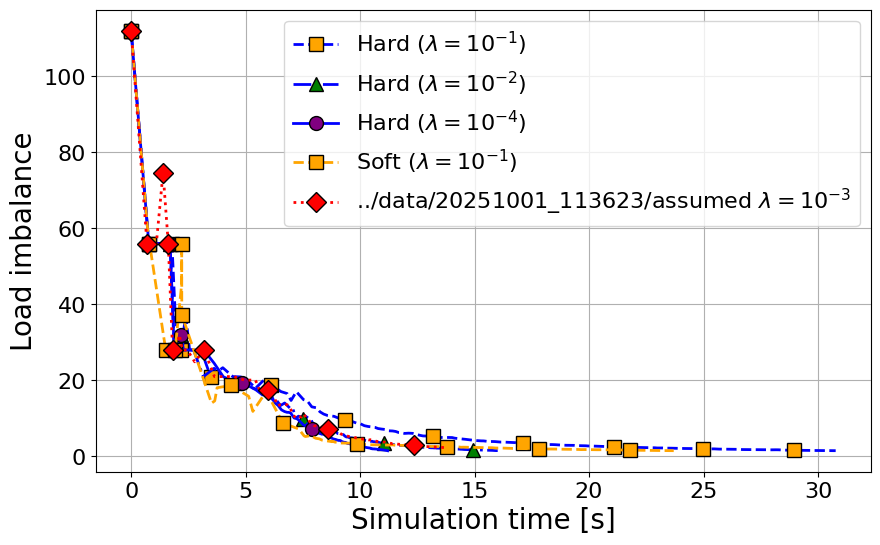

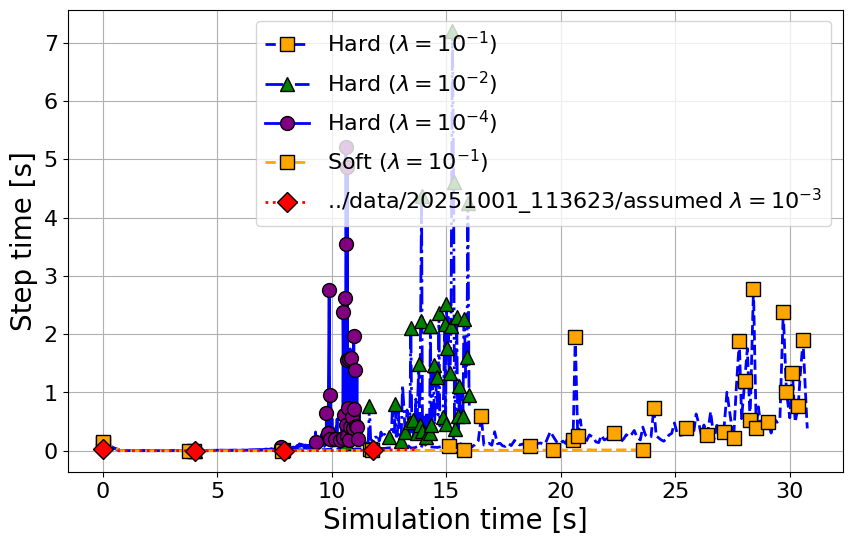

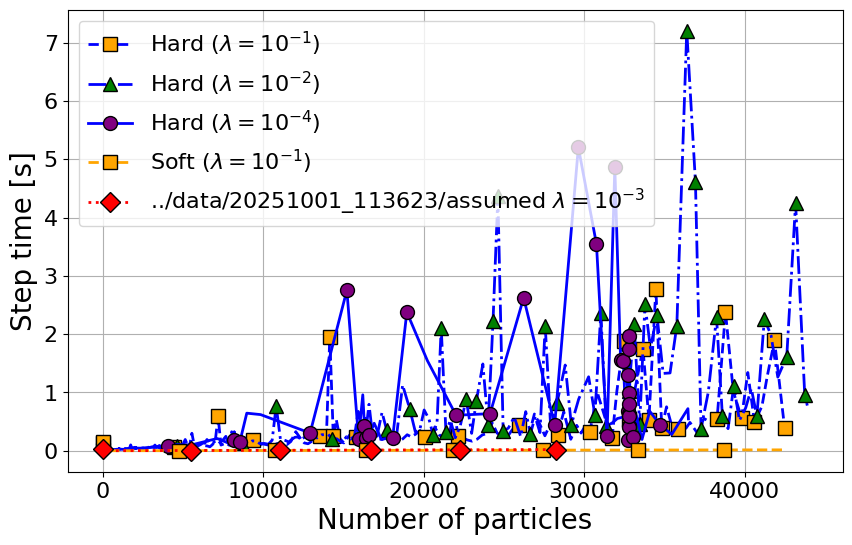

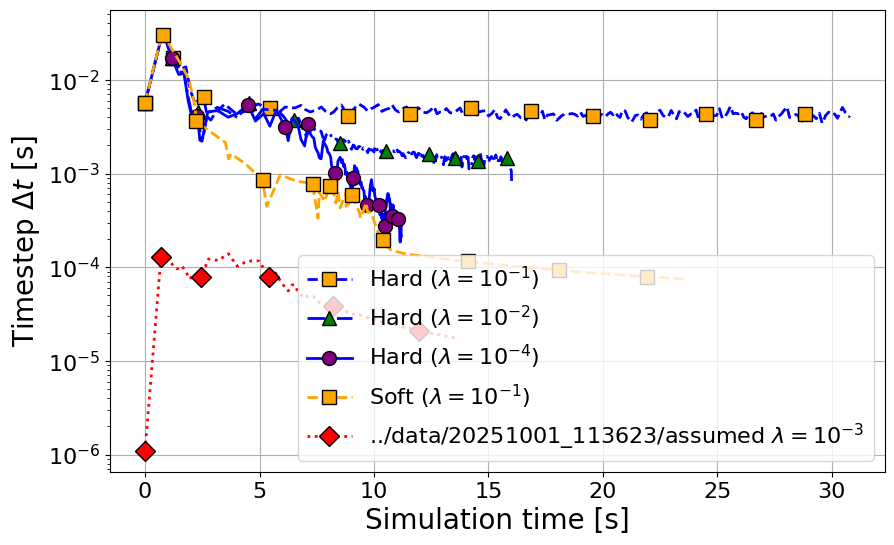

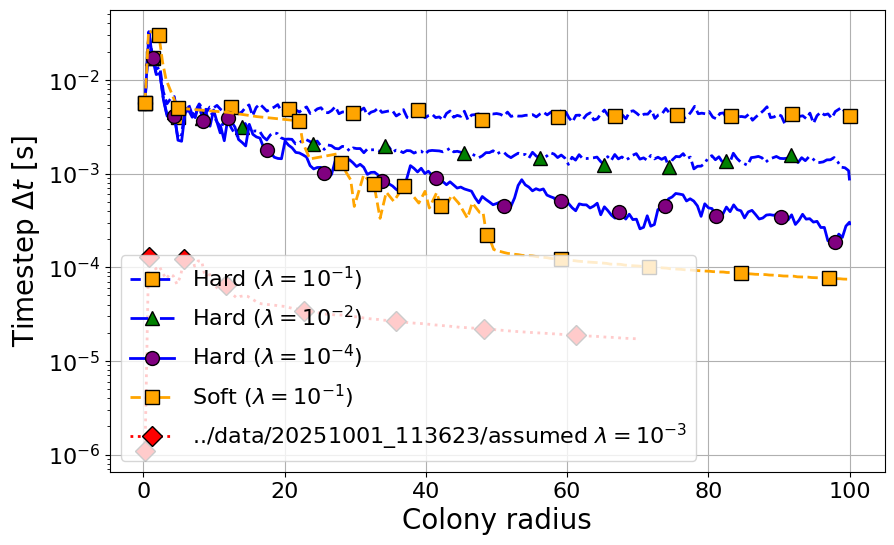

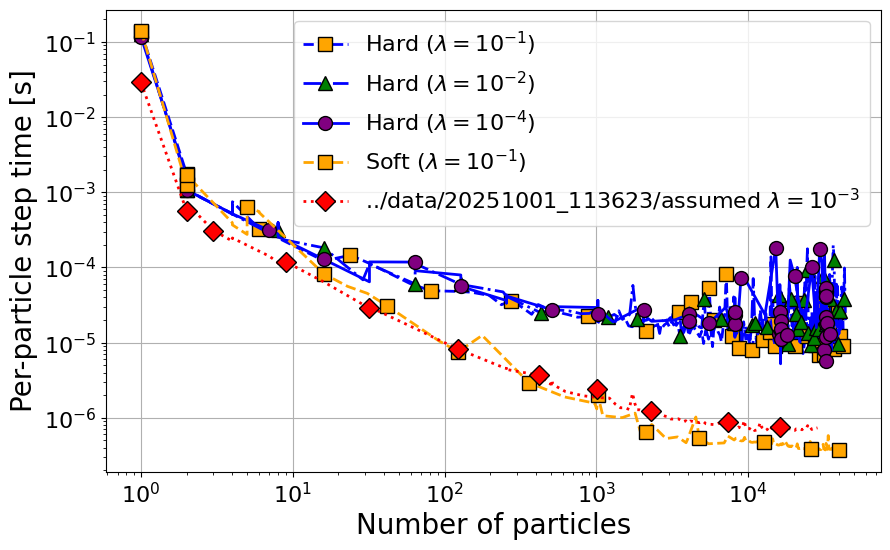

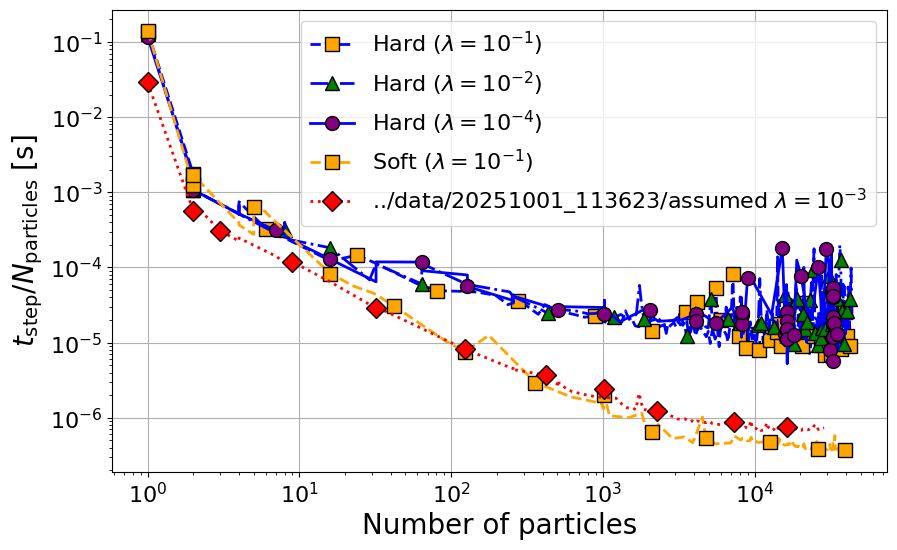

In [40]:
bin_size = 2.0

# Radial profiles (binned averages)
plot_radial_distribution(particles_dict, "length", bin_size,
                         xlabel="Radius $r$", ylabel="$\\langle \\text{length} \\rangle$")
plot_radial_distribution(particles_dict, "stress", bin_size, plot_theory=True,
                         xlabel="Radius $r$", ylabel="$\\langle \\text{stress} \\rangle$")
plot_radial_distribution(particles_dict, "packing_fraction", bin_size,
                         xlabel="Radius $r$", ylabel="$\\langle \\text{packing fraction} \\rangle$")
plot_radial_distribution(particles_dict, "impedance", bin_size,
                         xlabel="Radius $r$", ylabel="$\\langle \\text{impedance} \\rangle$")
plot_radial_distribution(particles_dict, "age", bin_size,
                         xlabel="Radius $r$", ylabel="$\\langle \\text{age} \\rangle$")
# plot_radial_distribution(particles_dict, "ldot", bin_size,
#                          xlabel="Radius $r$", ylabel="$\\langle \\dot{l} \\rangle$")
plot_radial_distribution(particles_dict, "mag_velocity_linear", bin_size,
                         xlabel="Radius $r$", ylabel="$\\langle |v_{\\text{lin}}| \\rangle$")
plot_radial_distribution(particles_dict, "mag_velocity_angular", bin_size,
                         xlabel="Radius $r$", ylabel="$\\langle |\\omega| \\rangle$")


# Parameter evolution / scaling plots
plot_parameter_over_time(sim_dict, "simulation_time [s]", "colony_radius",
                         xlabel="Simulation time [s]", ylabel="Colony radius")
plot_parameter_over_time(sim_dict, "colony_radius", "num_particles",
                         xlabel="Colony radius", ylabel="Number of particles")
plot_parameter_over_time(sim_dict, "num_particles", "num_constraints",
                         xlabel="Number of particles", ylabel="Number of constraints")
plot_parameter_over_time(sim_dict, "wall_time [s]", "num_particles",
                         xlabel="Wall time [s]", ylabel="Number of particles")
plot_parameter_over_time(sim_dict, "wall_time [s]", "colony_radius",
                         xlabel="Wall time [s]", ylabel="Colony radius")
plot_parameter_over_time(sim_dict, "simulation_time [s]", "colony_radius",
                         xlabel="Simulation time [s]", ylabel="Colony radius")
plot_parameter_over_time(sim_dict, "simulation_time [s]", "bbpgd_iterations",
                         xlabel="Simulation time [s]", ylabel="BBPGD iterations")
plot_parameter_over_time(sim_dict, "simulation_time [s]", "recursive_iterations",
                         xlabel="Simulation time [s]", ylabel="Recursive iterations")
plot_parameter_over_time(sim_dict, "simulation_time [s]", "num_particles",
                         xlabel="Simulation time [s]", ylabel="Number of particles")
plot_parameter_over_time(sim_dict, "colony_radius", "peak_memory_mb",
                         xlabel="Colony radius", ylabel="Peak memory [MB]")

plot_parameter_over_time(sim_dict, "simulation_time [s]", "load_imbalance",
                         xlabel="Simulation time [s]", ylabel="Load imbalance")

plot_parameter_over_time(sim_dict, "simulation_time [s]", "wall_time_per_step [s]",
                         xlabel="Simulation time [s]", ylabel="Step time [s]")
plot_parameter_over_time(sim_dict, "num_particles", "wall_time_per_step [s]",
                         xlabel="Number of particles", ylabel="Step time [s]")

plot_parameter_over_time(sim_dict, "simulation_time [s]", "dt", yscale="log",
                         xlabel="Simulation time [s]", ylabel="Timestep $\\Delta t$ [s]")
plot_parameter_over_time(sim_dict, "colony_radius", "dt", yscale="log",
                         xlabel="Colony radius", ylabel="Timestep $\\Delta t$ [s]")

plot_parameter_over_time(sim_dict, "num_particles", "wall_time_per_step_particle [s]",
                         yscale="log", xscale="log",
                         xlabel="Number of particles", ylabel="Per-particle step time [s]")
plot_parameter_over_time(sim_dict, "num_particles", "wall_time_per_step_particle [s]",
                         yscale="log", xscale="log",
                         xlabel="Number of particles", ylabel="$t_{\\text{step}} / N_{\\text{particles}}$ [s]")

In [41]:
# import seaborn as sns

# for key in sim_dict:
#     swarm_plot = sns.pairplot(sim_dict[key])
#     fig = swarm_plot.fig
#     fig.savefig(f"pairplot_sim_{key[0]}_{key[1]}.png", dpi=300, bbox_inches="tight")

# for key in particles_dict:
#     swarm_plot = sns.pairplot(particles_dict[key])
#     fig = swarm_plot.fig
#     fig.savefig(f"pairplot_particles_{key[0]}_{key[1]}.png", dpi=300, bbox_inches="tight")